# Final Project

## TRAC2- Baseline Models

In this notebook we build the baseline models for the TRAC-2 dataset. 

Characteristics of the models:
- Neural Bag of Words architecture
- A single dense layer with dropout
- Use Glove embeddings (dim=300) without fine tuning them
- Maximum sequence length is 150
- Use keras tokenizer




## Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
import tensorflow.keras.backend as K
# for hyperparameter tunning
from keras_tuner import HyperModel
import keras_tuner as kt
# import sklearn to calculate the metrics
from sklearn import metrics

from sklearn.preprocessing import label_binarize

In [2]:
print(tf.__version__)

2.6.0


## Load data
Load training, development and test datasets.

In [3]:
# Load aggressiveness dataset
train_data = pd.read_csv('../../../data/release-files/eng/trac2_eng_train.csv')
dev_data = pd.read_csv('../../../data/release-files/eng/trac2_eng_dev.csv')

# test data data and labels is in separate files
test_data = pd.read_csv('../../../data/release-files/test/trac2_eng_test.csv')
test_labels_a = pd.read_csv('../../../data/release-files/gold/trac2_eng_gold_a.csv')
test_labels_b = pd.read_csv('../../../data/release-files/gold/trac2_eng_gold_b.csv')

## Helper functions

In [4]:
def from_prob_to_labels(model, x, task):
    '''
    Returns labels based on predicted probability on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    model: trained model
    x: input data
    task: either 'A' or 'B'
    '''
    pred = model.predict(x)
    
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
        labels = np.where(pred <0.5, 'NGEN', 'GEN')
    else:
        labels = []
        
    return labels    

In [5]:
def to_binary_labels(string_labels, classes_list):
    '''
    Returns an array with 0 and 1 for a binary classification problem.
    Parameters:
    string_labels: array with 2 categories defined as strings e.g. ['cat', 'dog', 'dog', ...] 
    classes_list: array with the two classes. The order of the array defines which gets 0 and which gets 1. The first
                  gets 0.
    '''

    labels = label_binarize(string_labels, classes = classes_list).flatten()
    
    return labels 

In [6]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [7]:
def confusion_matrix_plot(model, input_data, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    model: trained model
    input data: data we want to use to evaluate the model
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # get predicted labels
    pred_labels = from_prob_to_labels(model, input_data, task)
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


In [8]:
def loss_accuracy_plots(training_history, xrange, task):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # loss plot
    ax1.plot(training_history.history['loss'], color='black')
    ax1.plot(training_history.history['val_loss'], color='blue')
    ax1.set_title('Training and validation loss Sub-Task ' + task)
    ax1.legend(['training', 'development'])
    ax1.grid(which='both')
    ax1.set_xticks(np.arange(0, xrange, 2))
    
    # accuracy plot
    if task == 'A':
        ax2.plot(training_history.history['categorical_accuracy'], color='black')
        ax2.plot(training_history.history['val_categorical_accuracy'], color='blue')
        ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
        ax2.legend(['training', 'development'])
        ax2.grid(which='both')
        ax2.set_xticks(np.arange(0, xrange, 2))
    elif task == 'B':
        ax2.plot(training_history.history['binary_accuracy'], color='black')
        ax2.plot(training_history.history['val_binary_accuracy'], color='blue')
        ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
        ax2.legend(['training', 'development'])
        ax2.grid(which='both')
        ax2.set_xticks(np.arange(0, xrange, 2))
    plt.show()
    

## Prepare the data for modeling


In [9]:
# create arrays of text examples for train, development and test data
train_text = np.array(train_data['Text'])
dev_text = np.array(dev_data['Text'])
test_text = np.array(test_data['Text'])

In [10]:
# create arrays of labels for train, development and test data

# Sub-Task A
train_labels_a = np.array(train_data['Sub-task A'])
dev_labels_a = np.array(dev_data['Sub-task A'])
test_labels_a = np.array(test_labels_a['Sub-task A'])

# Sub-Task B
# create arrays of labels for train, development and test data
train_labels_b = np.array(train_data['Sub-task B'])
dev_labels_b = np.array(dev_data['Sub-task B'])
test_labels_b = np.array(test_labels_b['Sub-task B'])

In [11]:
# encode labels

# Sub-Task A - [CAG,NAG,OAG]
train_labels_a_enc = to_one_hot_labels(train_labels_a)
dev_labels_a_enc = to_one_hot_labels(dev_labels_a)
test_labels_a_enc = to_one_hot_labels(test_labels_a)

# Sub-Task B
# encode the labels. As this is a binary classification we use binary labels 0:NGEN, 1:GEN
train_labels_b_enc = to_binary_labels(train_labels_b, classes_list=['NGEN', 'GEN'])
dev_labels_b_enc = to_binary_labels(dev_labels_b, classes_list=['NGEN', 'GEN'])
test_labels_b_enc = to_binary_labels(test_labels_b, classes_list=['NGEN', 'GEN'])


In [12]:
# load pre-trained word embeddings. In this case Glove
# This is commented out to avoid downloading it again
# !wget http://nlp.stanford.edu/data/glove.6B.zip -P ~/data/

In [13]:
# unzip the file
# commented out for the same reason above
# !unzip ~/data/glove.6B.zip -d ~/data/

In [14]:
# path to glove file- will use the embeddings with dimension = 300
glove_file ="../../../data/glove.6B.300d.txt"

In [15]:
# create a vocabulary index 
# consider this maximum number of words- Played with larger vocab sizes, but 10,000 is enough.
max_tokens = 10000
# truncate or pad sequences to be this long
max_sequence_lenght = 150

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_sequence_lenght)

2021-10-03 17:18:45.639252: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# train vocabulary
vectorizer.adapt(train_text)

# save vocabulary in a variable
vocab = vectorizer.get_vocabulary()

2021-10-03 17:18:47.748443: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
print(f'Vocabulary has {len(vocab)} words.')

Vocabulary has 10000 words.


In [18]:
# inspect the vocabulary first words
vocab[:10]

['', '[UNK]', 'the', 'and', 'is', 'to', 'a', 'of', 'i', 'you']

In [19]:
# see how it works with a test sentence
# 0 is reserved for padding and index 1 is reserved for out of vocabulary tokens
example_sentence = 'Of all the places to travel, Spain is at the top of my list.'
vectorizer(example_sentence)

<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([   7,   35,    2, 2175,    5,    1,    1,    4,   88,    2,  480,
          7,   54,  921,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [20]:
# create an index for each word {word: index}
word_idx = dict(zip(vocab, range(len(vocab))))

In [21]:
# Map words with their vector representation (embeddings)
embeddings_glove = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_glove[word] = coefs

print(f'Number of embeddings available: {len(embeddings_glove)}')

Number of embeddings available: 400000


In [22]:
# just to check let's get the dimensions of one of the embeddings
embeddings_glove['home'].shape

(300,)

In [23]:
# build embedding matrix to use it in the model
dimensions_emb = 300
# the plus two is for padding and unknown tokens
total_tokens = len(vocab) + 2
with_embedding = []
without_embedding = []

# initialize embedding matrix with zeroes
embedding_matrix = np.zeros((total_tokens, dimensions_emb))

for word, index in word_idx.items():
    emb_vector = embeddings_glove.get(word)
    # add to matrix
    # count converted and not converted words
    if emb_vector is not None:
        embedding_matrix[index] = emb_vector
        with_embedding.append(word)
    else:
        without_embedding.append(word)

print(f'Number of words with embeddings found: {len(with_embedding)}')
print(f'Number of words with embeddings NOT found: {len(without_embedding)}')

Number of words with embeddings found: 6928
Number of words with embeddings NOT found: 3072


In [24]:
# Let's explore the words with no embedding available in glove
# Most of them are typos, some emoticons, unrecognized characters
without_embedding[:50]

['',
 '[UNK]',
 'shwetabh',
 'chutiya',
 '😂',
 'don’t',
 '498a',
 'it’s',
 '👍',
 '👌',
 '😍',
 '😂😂',
 'borade',
 'i’m',
 '🙏',
 '😂😂😂😂',
 '😂😂😂',
 'tshirt',
 '🔥',
 'arundati',
 '🤣',
 '💯',
 '🤣🤣🤣',
 '😊',
 'vedio',
 'shahids',
 'mensutra',
 'kutiya',
 'can’t',
 'arundathi',
 '😂😂😂😂😂',
 '😁',
 '👍👍',
 'that’s',
 'ryt',
 'plzz',
 'antinational',
 'yess',
 'pubg',
 'misandrists',
 'didn’t',
 'bcz',
 'bcoz',
 'arundhuti',
 '09777070288',
 '🤣🤣',
 '🙌',
 '😅',
 '👍👍👍',
 '👌👌']

In [25]:
# does glove recognize some emoticons? No
a_smile = '😁'
a_smile in without_embedding

True

In [26]:
# what about the most basic smile? No
a_smile2 = '😊'
a_smile in without_embedding

True

In [27]:
# prepare input data for the model
# convert the train sentences to sequences of ids
train_input = vectorizer(train_text)

In [28]:
# check the dimensions
# looks good: number examples and 150 max lenght
train_input.shape

TensorShape([4263, 150])

In [29]:
# do the same for development and test data
dev_input = vectorizer(dev_text)
test_input = vectorizer(test_text)

## Model Task A

In [30]:
# delete model if exists
try:
    del BOW_model_A
except:
    pass

In [31]:
# Define the model

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_A = tf.keras.Sequential()
# include the embedding layer
BOW_model_A.add(embedding_layer)
# average embedding vectors
BOW_model_A.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_A.add(Dense(100, activation='relu'))  
# dropout layer for regularization
BOW_model_A.add(Dropout(0.2))
# output layer with 3 classes classification
BOW_model_A.add(Dense(3, activation='softmax'))

In [32]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
BOW_model_A.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])

In [33]:
# summary of the model's architecture
BOW_model_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          3000600   
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 3,031,003
Trainable params: 30,403
Non-trainable params: 3,000,600
_________________________________________________________________


In [34]:
# train the model and store the training history
training_history = BOW_model_A.fit(train_input, train_labels_a_enc, validation_data=(dev_input, dev_labels_a_enc),epochs=50, verbose=0)

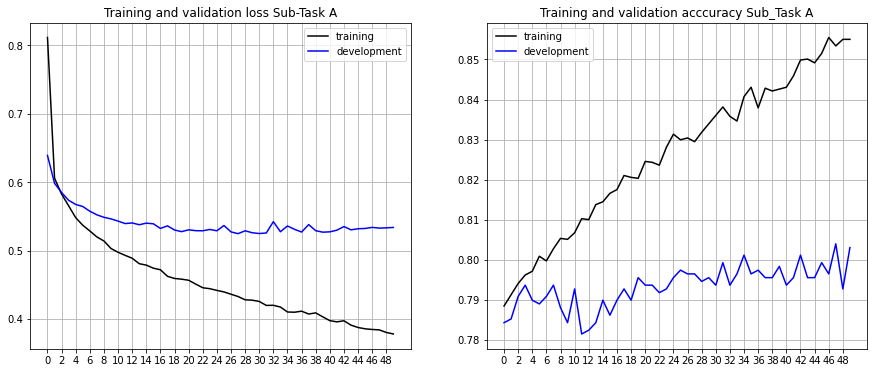

In [35]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='A')

This model is clearly overfitting. Let's simplify the model by reducing the number of neurons in the dense layer. We are going try with 20 neurons instead of 100.

In [36]:
# delete model if exists
try:
    del BOW_model_A
except:
    pass

In [37]:
# Define the model- Now with less neurons in the dense layer. 

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_A = tf.keras.Sequential()
# include the embedding layer
BOW_model_A.add(embedding_layer)
# average embedding vectors
BOW_model_A.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_A.add(Dense(20, activation='relu'))  
# dropout layer for regularization
BOW_model_A.add(Dropout(0.2))
# output layer with 3 classes classification
BOW_model_A.add(Dense(3, activation='softmax'))

In [38]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
BOW_model_A.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])

In [39]:
# train the model and store the training history
training_history = BOW_model_A.fit(train_input, train_labels_a_enc, validation_data=(dev_input, dev_labels_a_enc),epochs=50, verbose=0)

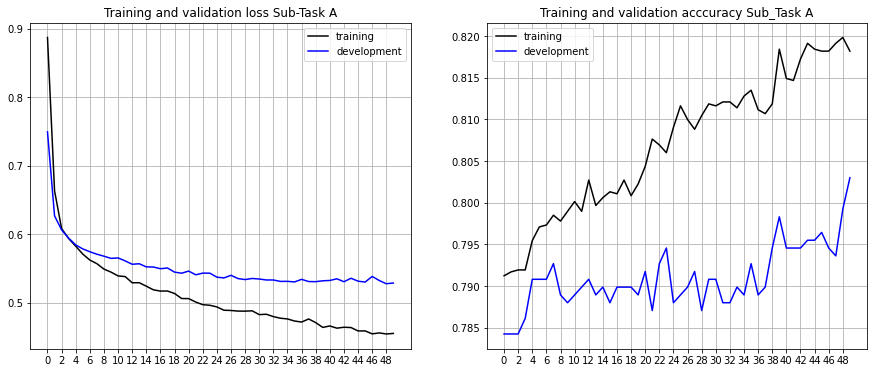

In [40]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='A')

The model is better but still overfitting. Let's reduce the number of neurons even more: 10 neurons.

In [41]:
# delete model if exists
try:
    del BOW_model_A
except:
    pass

In [42]:
# Define the model- Now with less neurons in the dense layer. 

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_A = tf.keras.Sequential()
# include the embedding layer
BOW_model_A.add(embedding_layer)
# average embedding vectors
BOW_model_A.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_A.add(Dense(10, activation='relu'))  
# dropout layer for regularization
BOW_model_A.add(Dropout(0.2))
# output layer with 3 classes classification
BOW_model_A.add(Dense(3, activation='softmax'))

In [43]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
BOW_model_A.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])

In [44]:
# train the model and store the training history
training_history = BOW_model_A.fit(train_input, train_labels_a_enc, validation_data=(dev_input, dev_labels_a_enc),epochs=50, verbose=0)

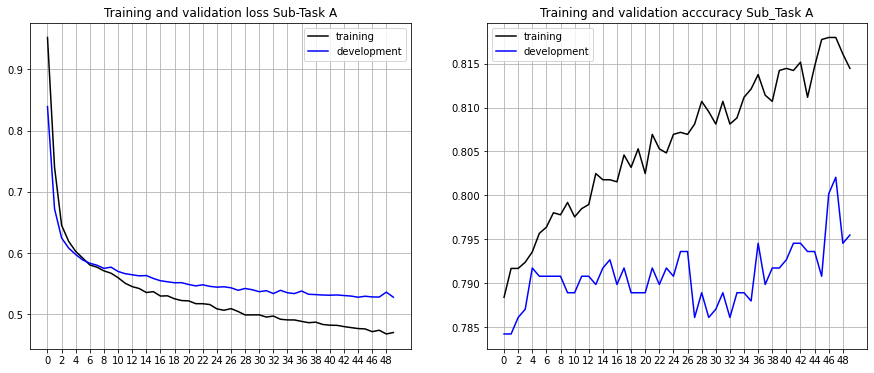

In [45]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='A')

Now the loss curve is looking better. Let's reduce the number of epochs to 20 to help prevent overfitting even further. 

In [46]:
# delete model if exists
try:
    del BOW_model_A
except:
    pass

In [47]:
# Define the model- Now with less neurons in the dense layer. 

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_A = tf.keras.Sequential()
# include the embedding layer
BOW_model_A.add(embedding_layer)
# average embedding vectors
BOW_model_A.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_A.add(Dense(10, activation='relu'))  
# dropout layer for regularization
BOW_model_A.add(Dropout(0.2))
# output layer with 3 classes classification
BOW_model_A.add(Dense(3, activation='softmax'))

In [48]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
BOW_model_A.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])

In [49]:
# train the model and store the training history
training_history = BOW_model_A.fit(train_input, train_labels_a_enc, validation_data=(dev_input, dev_labels_a_enc),epochs=20, verbose=0)

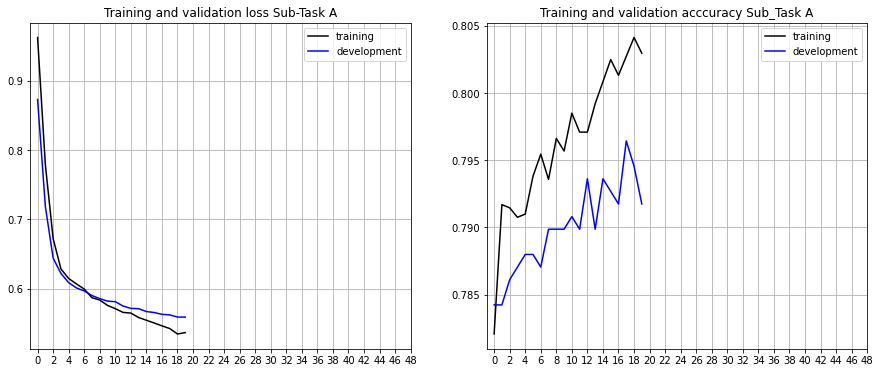

In [50]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='A')

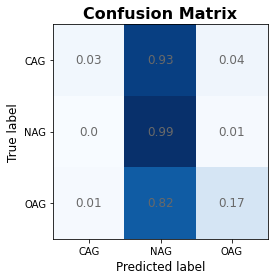

              precision    recall  f1-score   support

         CAG      0.560     0.031     0.059       453
         NAG      0.811     0.990     0.892      3375
         OAG      0.613     0.168     0.264       435

    accuracy                          0.804      4263
   macro avg      0.662     0.396     0.405      4263
weighted avg      0.764     0.804     0.739      4263

Weighted f1-score: 0.7390293220689647


In [51]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train = from_prob_to_labels(BOW_model_A, train_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_A, train_input, train_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_a, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_a, pred_labels_train, pos_label=1, average='weighted')}")

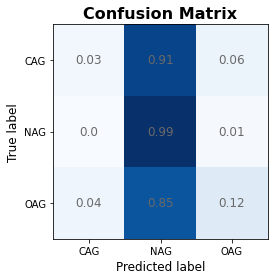

              precision    recall  f1-score   support

         CAG      0.444     0.034     0.063       117
         NAG      0.804     0.989     0.887       836
         OAG      0.464     0.115     0.184       113

    accuracy                          0.792      1066
   macro avg      0.571     0.379     0.378      1066
weighted avg      0.728     0.792     0.722      1066

Weighted f1-score: 0.7220292169147924


In [52]:
# Evaluate model on DEVELOPMENT data

# predict labels using the development data
pred_labels_dev = from_prob_to_labels(BOW_model_A, dev_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_A, dev_input, dev_labels_a, task='A', normalize='true')

# Print the precision, recall, f1
print(metrics.classification_report(dev_labels_a, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_a, pred_labels_dev, pos_label=1, average='weighted')}")

#### Hyperparamters selection using random search

Let's experiment more with the number of neurons in the dense layer. For that, we are going to use the Keras random search capabilities. Also, we are going to experiment with the dropout rate.

Two hyperparameters:
- Number of neurons in the dense layer
- Dropout rate

In [53]:
# first we need to define a hypermodel using a model builder function
# same model architecture we used earlier

def model_builder(hp):
    
    # sequential model
    model = tf.keras.Sequential()
        
    # embedding layer
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                        input_length=max_sequence_lenght,
                        trainable=False))
        
    # average embedding vectors
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
        
    # hidden layer
    hp_units = hp.Int('units', min_value=5, max_value=20, step=1)
    model.add(Dense(units=hp_units, activation='relu'))

    # dropout layer 
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])
    
    return model

In [54]:
# remove folder if exists to avoid error
!rm -r ./hp_search_BOW_task_A

rm: cannot remove './hp_search_BOW_task_A': No such file or directory


In [55]:
tuner = kt.RandomSearch(model_builder, objective='val_categorical_accuracy', max_trials=10, directory='hp_search_BOW_task_A')

In [56]:
tuner.search(train_input, train_labels_a_enc, validation_data=(dev_input, dev_labels_a_enc), epochs=50, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [57]:
# delete model if exists
try:
    del BOW_model_A_optimized
except:
    pass

In [58]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
# Reinstantiate the (untrained) best model found during the search process.
BOW_model_A_optimized = tuner.hypermodel.build(best_hp)

In [59]:
print(f"The optimal number of units in the hidden layer is {best_hp.get('units')} and the optimal dropout is {best_hp.get('dropout')}.")

The optimal number of units in the hidden layer is 10 and the optimal dropout is 0.3.


In [60]:
training_history = BOW_model_A_optimized.fit(train_input, train_labels_a_enc, validation_data=(dev_input, dev_labels_a_enc), epochs=50, verbose=0)

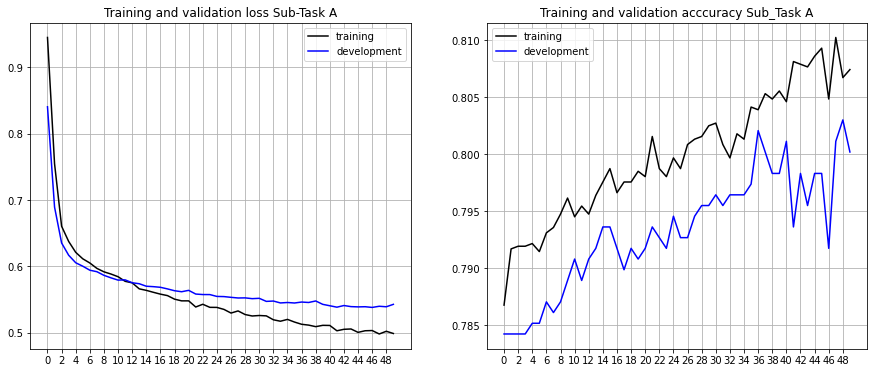

In [61]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='A')

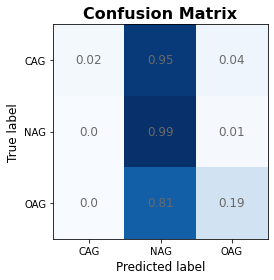

              precision    recall  f1-score   support

         CAG      0.778     0.015     0.030       453
         NAG      0.811     0.993     0.893      3375
         OAG      0.681     0.186     0.292       435

    accuracy                          0.807      4263
   macro avg      0.756     0.398     0.405      4263
weighted avg      0.794     0.807     0.740      4263

Weighted f1-score: 0.7397870970797192


In [65]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train = from_prob_to_labels(BOW_model_A_optimized, train_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_A_optimized, train_input, train_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_a, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_a, pred_labels_train, pos_label=1, average='weighted')}")

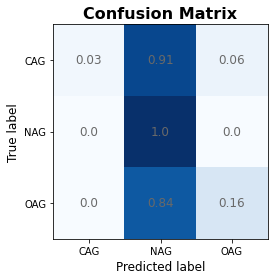

              precision    recall  f1-score   support

         CAG      1.000     0.026     0.050       117
         NAG      0.805     0.995     0.890       836
         OAG      0.621     0.159     0.254       113

    accuracy                          0.800      1066
   macro avg      0.808     0.393     0.398      1066
weighted avg      0.807     0.800     0.730      1066

Weighted f1-score: 0.7302099152691227


In [66]:
# Evaluate model on DEVELOPMENT data

# predict labels using the development data
pred_labels_dev = from_prob_to_labels(BOW_model_A_optimized, dev_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_A_optimized, dev_input, dev_labels_a, task='A', normalize='true')

# Print the precision, recall, f1
print(metrics.classification_report(dev_labels_a, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_a, pred_labels_dev, pos_label=1, average='weighted')}")

The model seems more stable in terms of overfitting. We select this model. 

Review the performance of the selected model in the test data:

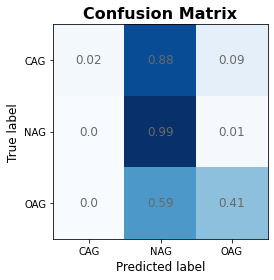

              precision    recall  f1-score   support

         CAG      0.833     0.022     0.043       224
         NAG      0.651     0.991     0.786       690
         OAG      0.811     0.406     0.541       286

    accuracy                          0.671      1200
   macro avg      0.765     0.473     0.457      1200
weighted avg      0.723     0.671     0.589      1200

Weighted f1-score: 0.5888141359150025


In [67]:
# Now we can evaluate the optimized model on the TEST data.

# predict labels using the test data
pred_labels_test_a = from_prob_to_labels(BOW_model_A_optimized, test_input, 'A')

# Create confusion matrix
confusion_matrix_plot(BOW_model_A_optimized, test_input, test_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_a, pred_labels_test_a, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_a, pred_labels_test_a, pos_label=1, average='weighted')}")


In [68]:
# save model
BOW_model_A_optimized.save('./TRAC-2_saved_models/BOW_model_task_A')

2021-10-03 17:39:34.814560: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./TRAC-2_saved_models/BOW_model_task_A/assets


## Model Task B


In [69]:
# delete model if exists
try:
    del BOW_model_B
except:
    pass

In [70]:
# Define the model

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_B = tf.keras.Sequential()
# include the embedding layer
BOW_model_B.add(embedding_layer)
# average embedding vectors
BOW_model_B.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_B.add(Dense(100, activation='relu'))  
# dropout layer for regularization
BOW_model_B.add(Dropout(0.2))
# output layer with binary classification
BOW_model_B.add(Dense(1, activation='sigmoid'))

In [71]:
# compile the model
# binary_crossentropy: loss function appropiate for binary classification
# binary_accuracy: calculates how often predictions match binary labels
BOW_model_B.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'binary_crossentropy'])

In [72]:
BOW_model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          3000600   
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,030,801
Trainable params: 30,201
Non-trainable params: 3,000,600
_________________________________________________________________


In [73]:
# train the model and store the training history
training_history = BOW_model_B.fit(train_input, train_labels_b_enc, validation_data=(dev_input, dev_labels_b_enc), epochs=50, verbose=0)

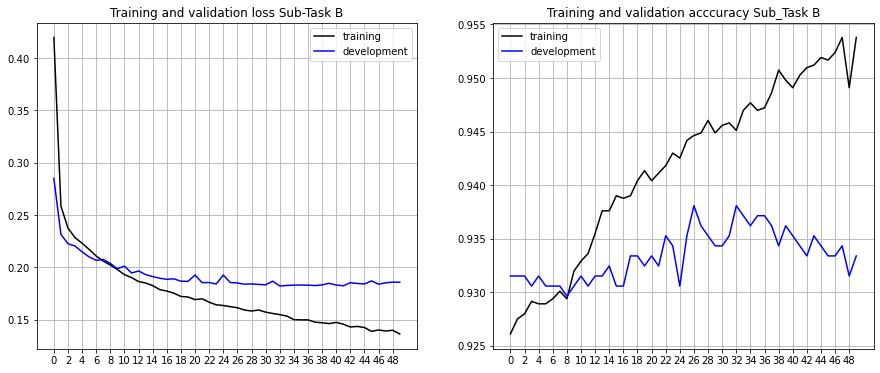

In [74]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='B')

Clearly the model is overfitting. Let's try with 10 neurons instead of 100 in the dense layer.

In [75]:
# delete model if exists
try:
    del BOW_model_B
except:
    pass

In [76]:
# Define the model

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_lenght,
                            trainable=False)

# simple sequential model
BOW_model_B = tf.keras.Sequential()
# include the embedding layer
BOW_model_B.add(embedding_layer)
# average embedding vectors
BOW_model_B.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
BOW_model_B.add(Dense(10, activation='relu'))  
# dropout layer for regularization
BOW_model_B.add(Dropout(0.2))
# output layer with binary classification
BOW_model_B.add(Dense(1, activation='sigmoid'))

In [77]:
# compile the model
# binary_crossentropy: loss function appropiate for binary classification
# binary_accuracy: calculates how often predictions match binary labels
BOW_model_B.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'binary_crossentropy'])

In [78]:
# train the model and store the training history
training_history = BOW_model_B.fit(train_input, train_labels_b_enc, validation_data=(dev_input, dev_labels_b_enc), epochs=50, verbose=0)

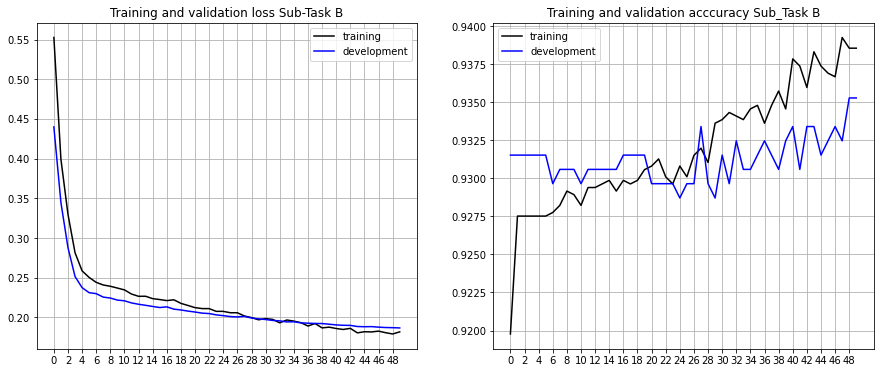

In [79]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='B')

The model looks good. 

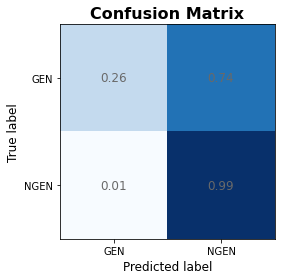

              precision    recall  f1-score   support

         GEN      0.782     0.256     0.385       309
        NGEN      0.945     0.994     0.969      3954

    accuracy                          0.941      4263
   macro avg      0.863     0.625     0.677      4263
weighted avg      0.933     0.941     0.927      4263

Weighted f1-score: 0.9266495955230913


In [82]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train_b = from_prob_to_labels(BOW_model_B, train_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B, train_input, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train_b, pos_label=1, average='weighted')}")

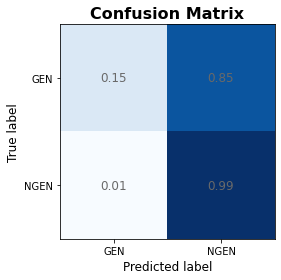

              precision    recall  f1-score   support

         GEN      0.611     0.151     0.242        73
        NGEN      0.941     0.993     0.966       993

    accuracy                          0.935      1066
   macro avg      0.776     0.572     0.604      1066
weighted avg      0.918     0.935     0.917      1066

Weighted f1-score: 0.9165835299963717


In [83]:
# Evaluate model on DEVELOPMENT data

# predict labels using the development data
pred_labels_dev_b = from_prob_to_labels(BOW_model_B, dev_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B, dev_input, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev_b, pos_label=1, average='weighted')}")

#### Hyperparamters selection using random search

Let's experiment more with the number of neurons in the dense layer. For that, we are going to use the Keras random search capabilities. Also, we are going to experiment with the dropout rate.

Two hyperparameters:
- Number of neurons in the dense layer
- Dropout rate

In [84]:
# first we need to define a hypermodel using a model builder function
# same model architecture we used earlier

def model_builder_b(hp):
    
    # sequential model
    model = tf.keras.Sequential()
        
    # embedding layer
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                        input_length=max_sequence_lenght,
                        trainable=False))
        
    # average embedding vectors
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
        
    # hidden layer
    hp_units = hp.Int('units', min_value=5, max_value=20, step=1)
    model.add(Dense(units=hp_units, activation='relu'))

    # dropout layer 
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'binary_crossentropy'])
    
    return model

In [85]:
# remove folder if exists to avoid error
!rm -r ./hp_search_BOW_task_B

rm: cannot remove './hp_search_BOW_task_B': No such file or directory


In [86]:
tuner_b = kt.RandomSearch(model_builder_b, objective='val_binary_accuracy', max_trials=10, directory='hp_search_BOW_task_B')

In [87]:
tuner_b.search(train_input, train_labels_b_enc, validation_data=(dev_input, dev_labels_b_enc), epochs=50, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [88]:
# Best hyperparameters
best_hp_b = tuner_b.get_best_hyperparameters()[0]
# Reinstantiate the (untrained) best model found during the search process.
BOW_model_B_optimized = tuner_b.hypermodel.build(best_hp_b)

In [89]:
print(f"The optimal number of units in the hidden layer is {best_hp_b.get('units')} and the optimal dropout is {best_hp_b.get('dropout')}.")

The optimal number of units in the hidden layer is 9 and the optimal dropout is 0.2.


In [90]:
training_history = BOW_model_B_optimized.fit(train_input, train_labels_b_enc, validation_data=(dev_input, dev_labels_b_enc),epochs=50, verbose=0)

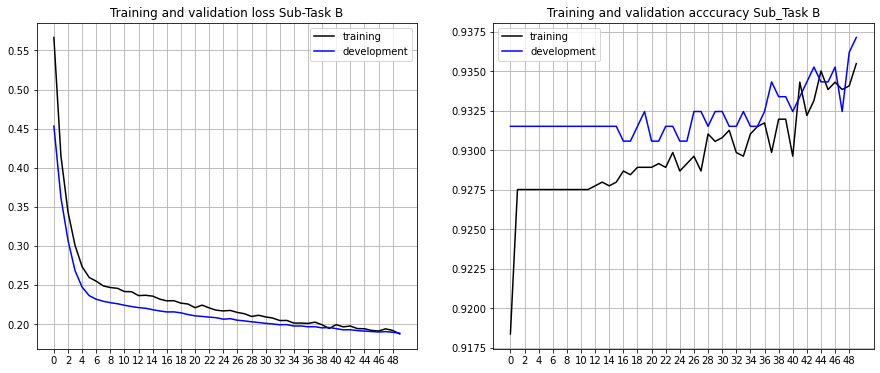

In [91]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=50, task='B')

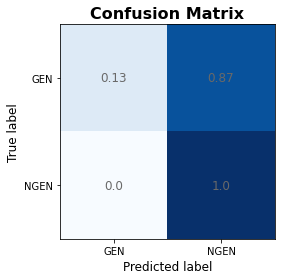

              precision    recall  f1-score   support

         GEN      0.911     0.133     0.232       309
        NGEN      0.936     0.999     0.967      3954

    accuracy                          0.936      4263
   macro avg      0.924     0.566     0.599      4263
weighted avg      0.935     0.936     0.913      4263

Weighted f1-score: 0.9134341567205732


In [97]:
# Evaluate model on TRAINING data

# predict labels using the training data
pred_labels_train_b = from_prob_to_labels(BOW_model_B_optimized, train_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B_optimized, train_input, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train_b, pos_label=1, average='weighted')}")

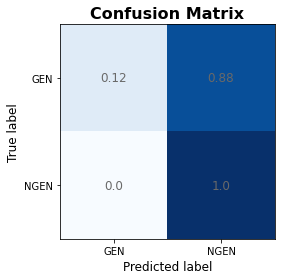

              precision    recall  f1-score   support

         GEN      0.750     0.123     0.212        73
        NGEN      0.939     0.997     0.967       993

    accuracy                          0.937      1066
   macro avg      0.845     0.560     0.590      1066
weighted avg      0.926     0.937     0.916      1066

Weighted f1-score: 0.9155320016042815


In [98]:
# Evaluate model on DEVELOPMENT data

# predict labels using the development data
pred_labels_dev_b = from_prob_to_labels(BOW_model_B_optimized, dev_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B_optimized, dev_input, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev_b, pos_label=1, average='weighted')}")

The model performance does not improve with respect to the model we had before the hyperparameter tunning. However, it seems more stable with respect to overfitting.

Review the performance of the selected model in the test data:

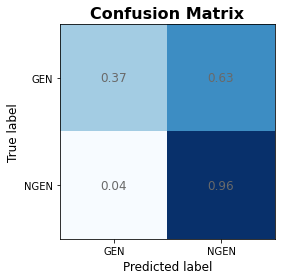

              precision    recall  f1-score   support

         GEN      0.582     0.366     0.449       175
        NGEN      0.898     0.955     0.926      1025

    accuracy                          0.869      1200
   macro avg      0.740     0.660     0.687      1200
weighted avg      0.852     0.869     0.856      1200

Weighted f1-score: 0.856257517315748


In [99]:
# Now we can evaluate the optimized model on the TEST data.

# predict labels using the test data
pred_labels_test_b = from_prob_to_labels(BOW_model_B_optimized, test_input, 'B')

# Create confusion matrix
confusion_matrix_plot(BOW_model_B_optimized, test_input, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test_b, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test_b, pos_label=1, average='weighted')}")

In [100]:
# save model
BOW_model_B_optimized.save('./TRAC-2_saved_models/BOW_model_task_B')

INFO:tensorflow:Assets written to: ./TRAC-2_saved_models/BOW_model_task_B/assets


## Housekeeping
Delete hyper-parameter search folders. 


In [101]:
# remove hyper-parameter search directory
!rm -r ./hp_search_BOW_task_A
!rm -r ./hp_search_BOW_task_B

In [93]:
# to load models back
# BOW_model_A = tf.keras.models.load_model('./TRAC-2_saved_models/BOW_model_task_A')
# BOW_model_B = tf.keras.models.load_model('./TRAC-2_saved_models/BOW_model_task_B')

## References

- Using pre-trained word embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/

- Keras random search: https://keras.io/api/keras_tuner/tuners/random/#randomsearch-class
